# Notebook Overview

1. **Master**
    - 1.1 Packages
    - 1.2 Import raw data
    - 1.3 Cleaning
        - 1.3.1 Data
        - 1.3.2 Categories
        - 1.3.3 Titles
        - 1.3.4 Quality
    - 1.4 To csv
    - 1.5 Runtime
        - 1.5.1 Runtimes log
    - 1.6 Thumbnail Analysis
         - 1.6.1 to csv incl. thumbnails
         - 1.6.2 Runtime

2. **Descriptiv Statistics**
    - 2.1 Packages
    - 2.2 Import Data
    - 2.3 Tables
        - 2.3.1 Descriptive: Length, Views, Voting and Age
        - 2.3.2 Categories: Count
        - 2.3.3 Words in titles: Count
        - 2.3.4 Male and female name dummies:
    - 2.4 Plots
        - 2.4.1 Views
        - 2.4.2 Voting
        - 2.4.3 Age and Views
        - 2.4.4 Voting and Views
    - 2.5 Thumbnails
        - 2.5.1 Red
        - 2.5.2 Green
        - 2.5.3 Blue
        - 2.5.4 Light

3. **Machine Learning**
    - 3.1 Packages
    - 3.2 Import data
    - 3.3 Polynomial Features
    - 3.4 OLS
        - 3.4.1 OLS Learning curve
    - 3.5 LASSO
        - 3.5.1 LASSO Learning curve
        - 3.5.2 LASSO validation curve
    - 3.6 Elastic net
        - 3.6.1 Elastic Net learning curve
        - 3.6.2 Elastic Net validation curve
    - 3.7 Random forest regression

4. **Image Code**

# 1. Master

# 1.1 Packages

In [5]:
from timeit import default_timer as timer

start_manual = timer()

#Importing modules for cleaning data
import numpy as np
import pandas as pd
import nltk
import re
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
from nltk.corpus import stopwords
from datetime import date

# images
import requests
from PIL import Image
from io import BytesIO
from skimage import io, img_as_float
from urllib.request import urlopen
import os
from time import sleep

elapsed_time_packages = timer() - start_manual; print('sec:', round(elapsed_time_packages,2))

sec: 0.05


# 1.2 Import raw data

In [6]:
start_manual = timer()

#importing
df = pd.read_csv('tumbzilla_labels.csv', sep = ',')
df_lang = pd.read_csv('tumbzilla_labels_with_language.csv', sep = ',') #langdetect data
len(df) == len(df_lang)

# creating subset of df / removing all non-english titles
df['lang'] = df_lang.lang
df['prob'] = df_lang.prob
#print(len(df[df.lang == 'en']) / len(df) * 100) # 75% is english
df = df[df.lang == 'en']


df=df.sample(500, random_state=1234)
df.reset_index(inplace=True)

elapsed_time_import_raw_data = timer() - start_manual; print('sec:', round(elapsed_time_import_raw_data,2))

sec: 8.08


# 1.3 Cleaning Data

##  1.3.1 Dates

In [3]:
start_manual = timer()


#Check for missing values
digit_re = re.compile('(videos\/(?<=)(\d+\/\d+))')# compiled regular expression for matching digits

img_source=df.img_source

date_bool=img_source.apply(lambda x: len(digit_re.findall(x))>0)
string_short=img_source.apply(lambda x: digit_re.findall(x)[0]) 
# print(sum(date_bool))# Remember to check if we have any non missing variables.
# print(len(df))


#Extract dates
dates=string_short.copy()
for i in range(len(df)):
    dates.iloc[i]=string_short.iloc[i][1]


#Change to datetime
last_date = pd.to_datetime('2017/1/01') #last date from the used dataset 
df['last_date']=last_date
df['upload']=pd.to_datetime(dates, format='%Y%m/%d')


#Calculation the age
df['age'] = (last_date - df.upload) / np.timedelta64(1,'D')

elapsed_time_dates = timer() - start_manual; print('sec:', round(elapsed_time_dates,2))

sec: 0.19


## 1.3.2 Categories

In [4]:
start_manual = timer()

#Categories in lower case
category=df.categories.str.lower()

#Extracting categories
digit_re = re.compile('([a-z]+\s[a-z]+)|([a-z]+)') #'\s)?[a-z]+') # compiled regular expression for matching digits

df['cat_updated']=df.categories.str.replace(' ','')                      
df['cat_updated']=df['cat_updated'].apply(str)
df['cat_updated']=df.cat_updated.str.split("__")
df['cat_updated']=df.cat_updated.apply(str)

#Creating Bag of words
count=CountVectorizer()
docs=np.array(df.cat_updated)
bag=count.fit_transform(docs)

# ???
count_vocabulary=count.vocabulary_
categories_bag_of_words=bag.toarray()
categories_bag_of_words = pd.DataFrame(categories_bag_of_words)

# creating columnnames
cat_col = []
for i in range(categories_bag_of_words.shape[1]):
    cat_col.append('cat_' + str(i))
categories_bag_of_words.columns = cat_col    

# merging on df
df = df.join(categories_bag_of_words)

elapsed_time_categories = timer() - start_manual; print('sec:', round(elapsed_time_categories,2))

sec: 0.05


## 1.3.3 Titles

In [5]:
start_manual = timer()


#Titles in lower case
title=df.title
title_lower=title.str.lower()


#Creating list of stop words
stop_words = nltk.corpus.stopwords.words('english')

more_stop_words=['!', ',', '-', '.', '@', '\'', '/', '\'\'','&', '%', '(', ')', '#', 'gets', 'boor']
stop_words.extend(more_stop_words)
alphabet_stop_words=['b', 'c', 'd', 'e', 'f', 'g', 'h', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q','r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
stop_words.extend(alphabet_stop_words)


#Deleting stop words from titles
list=[]
for i in range(len(title_lower)): #len(title_lower), (number of titles/videos)
    word_tokens=nltk.word_tokenize(title_lower[i])
    filtered_sentence = []
    for w in word_tokens:
        if w not in stop_words:
            filtered_sentence.append(w)
    list.append(filtered_sentence)
title_lower_no_stopwords=list


#Creating name-lexicon
femalenames=pd.read_csv('dist_female_first.csv')
malenames=pd.read_csv('dist_male_first.csv')

for i in range(len(femalenames)):
    femalenames.iloc[i,0] = str(femalenames.iloc[i,0]).lower() #names in lower case 
    
for i in range(len(malenames)):
    malenames.iloc[i,0] = str(malenames.iloc[i,0]).lower() #names in lower case 
    
femalenames = pd.Series(femalenames.female_names, index=None)
malenames = pd.Series(malenames.male_names, index=None)
femalenames=femalenames.tolist()
malenames=malenames.tolist()
malenames_1=malenames.copy()

for i in range(len(malenames_1)) :
    if malenames_1[i] in femalenames:
        malenames.remove(malenames_1[i])

all_names=femalenames+malenames

#Updating name-lexicon
#create this list from bag of words in categories
cat=['60fps','amateur','anal', 'arab', 'asian', 'babe', 'babysitter', 'behindthescenes','bigass', 'bigdick', 'bigtits', 'blonde', 'blowjob', 'bondage', 'brazilian', 'british','brunette', 'bukkake', 'casting', 'celebrity', 'college', 'compilation', 'cosplay', 'creampie','cuckold', 'cumshots', 'czech', 'doublepenetration', 'ebony', 'euro', 'exclusive', 'fetish','fisting', 'forwomen', 'french', 'funny','gangbang', 'german', 'handjob', 'hardcore', 'hd','indian', 'interracial', 'italian', 'japanese', 'korean', 'latina', 'lesbian', 'massage','masturbation', 'mature', 'milf', 'music', 'nan', 'old', 'orgy','party', 'pissing', 'pornstar', 'pov','public', 'pussylicking', 'reality', 'redhead','roughsex', 'russian', 'school', 'smalltits','smoking', 'squirt', 'striptease', 'teen','threesome', 'toys', 'uniforms', 'verifiedamateurs','vintage', 'virtualreality', 'webcam', 'young']
delete_cat=[]


#identifying all names identical to a category
for i in cat:
    if i in all_names:
        delete_cat.append(i) 
    
#deleting all names identical to a category
for i in delete_cat: 
    all_names.remove(i)


delete_names=['dick', 'guy', 'art', 'young', 'max','long', 'angel', 'man', 'son','moon', 'summer','love', 'star', 'ginger','sun', 'cherry', 'spring','golden', 'buddy','sunny','april','august','queen','america', 'forest', 'mercy','destiny', 'france','honey','glory','dawn','tiny','candy','florida','lady','hung','diamond','valentine', 'faith', 'pearl', 'yung', 'kitty', 'bonny','autumn','chanel','miss','see','irish','princess','merry']#,, ]  #add fore words here if nessecary 
# deleting all names in 'delete_names'
for i in range(len(delete_names)): 
    if delete_names[i] in all_names:
        all_names.remove(delete_names[i])
 
   
femalenames_updated=[]
malenames_updated=[]

for i in range(len(all_names)):
    x=all_names[i]
    if x in femalenames:
        femalenames_updated.append(x)
for i in range(len(all_names)):
    x=all_names[i]
    if x in malenames:
        malenames_updated.append(x)


#Creating dummy variables for male and female names
### FEMALE NAMES ###
lex_f = femalenames_updated
L_master_f = []
female_name_dum= []

for j in range(len(title_lower_no_stopwords)):
    L_f = []
    for i in range(len(title_lower_no_stopwords[j])):
        temp = title_lower_no_stopwords[j][i]
        if (temp in lex_f) == True:
            succes = 1
        else:
            succes = 0
        L_f.append(succes)
    L_master_f.append(L_f)
    if sum(L_master_f[j]) > 0:
        d = 1
    else:
        d = 0
    female_name_dum.append(d)
df['female_name_dum'] = female_name_dum
    
### MALE NAMES ###
lex_m = malenames_updated
L_master_m = []
male_name_dum= []

for j in range(len(title_lower_no_stopwords)):
    L_m = []
    for i in range(len(title_lower_no_stopwords[j])):
        temp = title_lower_no_stopwords[j][i]
        if (temp in lex_m) == True:
            succes = 1
        else:
            succes = 0
        L_m.append(succes)
    L_master_m.append(L_m)
    if sum(L_master_m[j]) > 0:
        d = 1
    else:
        d = 0
    male_name_dum.append(d)
df['male_name_dum'] = male_name_dum
    
#Deleting names from titles
title_lower_no_stopwords=[' '.join(x) for x in title_lower_no_stopwords] #joining words into one string pr. title
title_lower_no_stopwords=pd.Series(title_lower_no_stopwords) #from list to Series

stop_words_names=all_names
lists=[]

for i in range(len(title_lower)-1): 
    word_tokens=nltk.word_tokenize(title_lower_no_stopwords[i])
    filtered_sentence = []
    for w in word_tokens:
        if w not in stop_words_names:
            filtered_sentence.append(w)
    lists.append(filtered_sentence)
title_lower_no_stopwords['title_test']=list
title_lower_noname=title_lower_no_stopwords['title_test']
# print(title_lower_noname)

title_lower_noname=[' '.join(x) for x in title_lower_noname] #joining words into one string pr. title


#Creating Bag of words
count=CountVectorizer()
docs=np.array(title_lower_noname)
bag=count.fit_transform(docs)

count_vocabulary=count.vocabulary_
title_bag_of_words=bag.toarray()
title_bag_of_words = pd.DataFrame(title_bag_of_words)

# creating columnnames
title_col = []
for i in range(title_bag_of_words.shape[1]):
    title_col.append('title_w_' + str(i))
title_bag_of_words.columns = title_col    

# merging on df
df = df.join(title_bag_of_words, rsuffix='_')

elapsed_time_titles = timer() - start_manual; print('sec:', round(elapsed_time_titles,2))

sec: 7.23


## 1.3.4 Quality

In [6]:
start_manual = timer()

#Creating dummy for quality
dummies = pd.get_dummies(df['quality']) #Generates two dummies, we keep only dummy for HD quality
HD=dummies.iloc[:,0]


# Merges quality dummy on to data 
datalist=[df,HD]
df=df.copy()
df['HD']=HD

elapsed_time_quality = timer() - start_manual; print('sec:', round(elapsed_time_quality,2))

sec: 0.06


# 1.4 to csv

In [7]:
start_manual = timer()

df_img_source = df #bruges til image code
col_del = ['index', 'Unnamed: 0', 'img_source', 'quality', 'title', 'video_link', 'categories', 'tags', 'lang', 'prob', 'last_date', 'upload', 'cat_updated']
df_klar = df.drop(labels=col_del, axis=1)
#df_klar.to_csv('df_5000.csv', index = None)

elapsed_time_df_5000 = timer() - start_manual; print('sec:', round(elapsed_time_df_5000,2))


sec: 0.01


# 1.5 Runtime 

In [8]:
print('Sample size: ' + str(len(df)))

print()

print('elapsed_time_packages: ' + str(round(elapsed_time_packages,2)))
print('elapsed_time_import_raw_data: ' + str(round(elapsed_time_import_raw_data,2)))
print('elapsed_time_dates: ' + str(round(elapsed_time_dates,2)))
print('elapsed_time_categories: ' + str(round(elapsed_time_categories,2)))
print('elapsed_time_titles: ' + str(round(elapsed_time_titles,2)))
print('elapsed_time_quality: ' + str(round(elapsed_time_quality,2)))
print('elapsed_time_df_5000: ' + str(round(elapsed_time_df_5000,2)))


print()

temp = elapsed_time_packages + elapsed_time_import_raw_data + elapsed_time_dates + elapsed_time_categories + elapsed_time_titles + elapsed_time_quality + elapsed_time_df_5000
print('Total runtime in sec: ' + str(round(temp,2)))

print()

temp2 = temp * (5000/len(df)) / 60 / 60
print('Runtime for all data in hours: ' + str(round(temp2,2)))


Sample size: 500

elapsed_time_packages: 3.53
elapsed_time_import_raw_data: 5.64
elapsed_time_dates: 0.19
elapsed_time_categories: 0.05
elapsed_time_titles: 7.23
elapsed_time_quality: 0.06
elapsed_time_df_5000: 0.01

Total runtime in sec: 16.72

Runtime for all data in hours: 0.05


## 1.5.1 Runtimes log

## 1.6 Thumbnail Analysis

In [1]:
start_manual = timer()

# importing df with img_source
df = df_img_source

#removing useless variables
col_del = ['index', 'Unnamed: 0', 'quality', 'title', 'video_link', 'categories', 'tags', 'lang', 'prob', 'last_date', 'upload', 'cat_updated']
df = df.drop(labels=col_del, axis=1)



# image code
m_col = []
n_row = []

df['red'] = 0
df['green'] = 0
df['blue'] = 0

light_score = []

required_sleep = 1

for i in range(len(df)):
    
    # download image________________________
    url = df.img_source.iloc[i]
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    image_path = '/Users/Nicklas/Desktop/thumbnail_' + str(i) + '.jpg'
    img.save(image_path)
    
    #process image________________________
    
    # size
    m_col.append(img.size[0])
    n_row.append(img.size[1])
    
    
    # RGB
    list_red = []
    list_green = []
    list_blue = []
    
    pix = img.load()
    
    for every_row in range(320): # for hver row..
        for every_col in range(180): #..loop gennem col
            list_red.append(pix[every_row,every_col][0])
            list_green.append(pix[every_row,every_col][1])
            list_blue.append(pix[every_row,every_col][2])
    df.red.iloc[i] = round(sum(list_red) / len(list_red),2)
    df.green.iloc[i] = round(sum(list_green) / len(list_green),2)
    df.blue.iloc[i] = round(sum(list_blue) / len(list_blue),2)
    
    # contrast
    img_grey = Image.open(BytesIO(response.content)).convert('LA')
    light_score.append(round(np.mean(img_grey),2))
    
    
    # delete image________________________
    os.remove(image_path)

    # sleep
    sleep(required_sleep)
    
df['m_col'] = m_col
df['n_row'] = n_row

df['light_score'] = light_score
    
elapsed_time_images = timer() - start_manual; print('sec:', round(elapsed_time_images,2))


NameError: name 'timer' is not defined

### 1.6.1 to csv incl. thumbnails

In [ ]:
start_manual = timer()


df_klar = df.drop(labels=['img_source', 'm_col', 'n_row'], axis=1)
#df_klar.to_csv('df_250_images.csv', index = None)

elapsed_time_df_250_images = timer() - start_manual; print('sec:', round(elapsed_time_df_250_images,2))


### 1.6.2 Runtime incl. thumbnails

In [3]:
print('Sample size: ' + str(len(df)))

print()

print('elapsed_time_packages: ' + str(round(elapsed_time_packages,2)))
print('elapsed_time_import_raw_data: ' + str(round(elapsed_time_import_raw_data,2)))
print('elapsed_time_dates: ' + str(round(elapsed_time_dates,2)))
print('elapsed_time_categories: ' + str(round(elapsed_time_categories,2)))
print('elapsed_time_titles: ' + str(round(elapsed_time_titles,2)))
print('elapsed_time_quality: ' + str(round(elapsed_time_quality,2)))
print('elapsed_time_df_5000: ' + str(round(elapsed_time_df_5000,2)))
print('elapsed_time_images: ' + str(round(elapsed_time_images,2)))
print('elapsed_time_df_250_images: ' + str(round(elapsed_time_df_250_images,2)))



print()

temp = elapsed_time_packages + elapsed_time_import_raw_data + elapsed_time_dates + elapsed_time_categories + elapsed_time_titles + elapsed_time_quality + elapsed_time_df_5000 + elapsed_time_images + elapsed_time_df_250_images
print('Total runtime in sec: ' + str(round(temp,2)))

print()

temp2 = temp * (5000/len(df)) / 60 / 60
print('Runtime for all data in hours: ' + str(round(temp2,2)))


SyntaxError: invalid syntax (<ipython-input-3-e722c0390e76>, line 26)

# 2. Descriptiv Statistics

## 2.1 Packages

In [1]:
import matplotlib.pyplot as plt
from  matplotlib.ticker import FuncFormatter
import numpy as np 
import pandas as pd
import seaborn as sns 
from matplotlib import pyplot

 
import numpy as np
import matplotlib.cbook as cbook
import matplotlib.dates as dates
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt



## 2.2 Import data

In [41]:
df_des=pd.read_csv('df_5000.csv') #This is a sample of the modified dataset on 5000 observations.
df_des.head()

,length,nb_views,voting,age,cat_0,cat_1,cat_2,cat_3,cat_4,cat_5,...,title_w_5150,title_w_5151,title_w_5152,title_w_5153,title_w_5154,title_w_5155,title_w_5156,title_w_5157,title_w_5158,HD
0,203.0,19260.0,64.0,1228.0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,770.0,93230.0,69.0,1687.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,430.0,18680.0,71.0,40.0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
3,606.0,3890000.0,73.0,547.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,1194.0,168070.0,83.0,1721.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
df_im=pd.read_csv('df_250_images.csv') #This is a sample of the modified dataset including the thumbnail features on 250 observations
df_im.head()

,length,nb_views,voting,age,cat_0,cat_1,cat_2,cat_3,cat_4,cat_5,...,title_w_751,title_w_752,title_w_753,title_w_754,title_w_755,HD,red,green,blue,light_score
0,203.0,19260.0,64.0,1228.0,1,0,0,0,0,0,...,0,0,0,0,0,0,31.74,10.10,3.64,135.22
1,770.0,93230.0,69.0,1687.0,0,0,0,0,0,0,...,0,0,0,0,0,0,112.16,75.48,47.77,168.87
2,430.0,18680.0,71.0,40.0,0,0,0,1,0,0,...,0,0,0,0,0,1,142.03,137.33,130.47,196.22
3,606.0,3890000.0,73.0,547.0,0,0,0,0,0,1,...,0,0,0,0,0,1,145.54,122.62,111.10,191.31
4,1194.0,168070.0,83.0,1721.0,0,0,0,0,0,0,...,0,0,0,0,0,0,155.08,119.10,102.01,191.20


## 2.3 Tables

###  2.3.1 Descriptive: Length, Views, Voting and Age

In [42]:
descr=df_des.describe()
des = descr.ix[:, :'age']
# des.to_csv('deskriptiv')
# des

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


### 2.3.2 Categories: Count

In [43]:
counts=[]
for i in range(4,85):
    temp = sum(df_des.iloc[:,i])
    counts.append(temp)

df_cat=pd.read_csv('category_count')
df_cat=df_cat.sort_values('0')
df_cat
dict_cat=df_cat.to_dict()
dictt=dict_cat.get('Unnamed: 0', {})
values=dictt.values()
cat=list(values) 
cat

df_cat2=pd.DataFrame(cat)
df_cat1=pd.DataFrame(counts)
df_cat2=df_cat2.join(df_cat1,rsuffix='_')

# df_cat2.to_csv('category_counts_excel_NEW4')
# df_cat2

### 2.3.3 Words in titles: Count

In [44]:
counts_w=[]
for i in range(88,5246):
    temp=sum(df_des.iloc[:,i])
    counts_w.append(temp)
counts_w

df_wor=pd.read_csv('words_NEW')
df_wor=df_wor.sort_values('0')
dict_wor=df_wor.to_dict()
dictt=dict_wor.get('index', {})
values=dictt.values()
wor=list(values) 

df_wor=pd.DataFrame(wor)
df_wor1=pd.DataFrame(counts_w)
df_wor=df_wor.join(df_wor1,rsuffix='_')

# df_wor.to_csv('word_counts_excel_NEW2')
# df_wor

### 2.3.4 Male and female name dummies:

In [45]:
female=df_des.female_name_dum 
male=df_des.male_name_dum

name=[]
no_name=[]

name.append(sum(female)/len(df))
name.append(sum(male)/len(df))
no_name.append((5000-sum(female))/len(df))
no_name.append((5000-sum(male))/len(df))

name=pd.DataFrame(name)
no_name=pd.DataFrame(no_name)
names=name.join(no_name,rsuffix='_')

## 2.4 Plots

### 2.4.1 Views

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


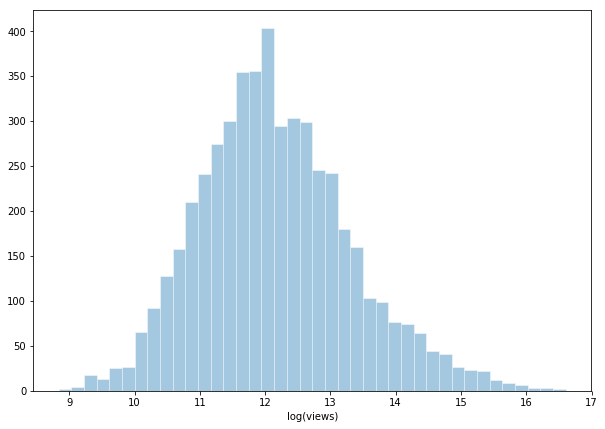

In [46]:
fig, ax = pyplot.subplots(figsize=(10,7))
ax=sns.distplot(np.log(df_des.nb_views), axlabel='log(views)',bins=40, kde=False, hist_kws=dict(edgecolor="white"))

# fig.savefig("views_hist.pdf", bbox_inches='tight')

### 2.4.2 Voting

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


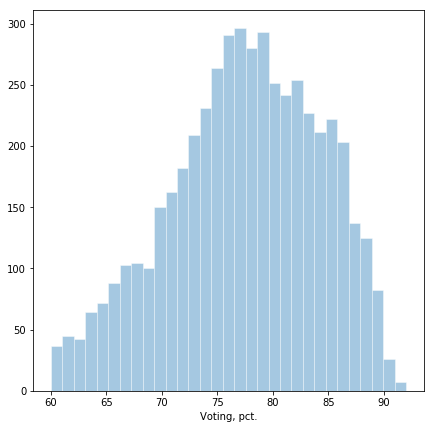

In [47]:
fig, ax = pyplot.subplots(figsize=(7,7))
ax=sns.distplot(df_des.voting, kde=False, hist_kws=dict(edgecolor="white"),axlabel='Voting, pct.')

# fig.savefig("voting_hist.pdf", bbox_inches='tight')

### 2.4.3 Age and Views

[Text(0,0.5,'Log(views)'), Text(0.5,0,'Days since upload of the video')]

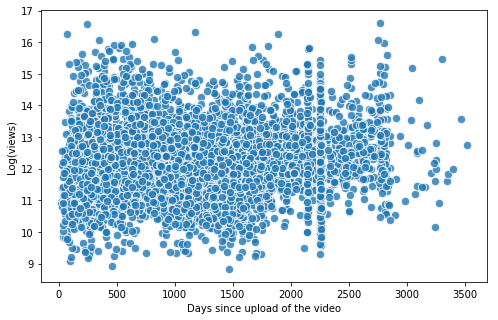

In [48]:
fig, ax = pyplot.subplots(figsize=(8,5))
ax=sns.regplot(x=df_des.age,y=np.log(df_des.nb_views),data=df_des,fit_reg=False,scatter_kws={'edgecolors': sns.xkcd_rgb['white'],'s': 70},)
ax.set(xlabel='Days since upload of the video', ylabel='Log(views)')

# fig.savefig("views_age.pdf", bbox_inches='tight')

### 2.4.4 Voting and Views

[Text(0,0.5,'Log(views)'), Text(0.5,0,'Voting, pct.')]

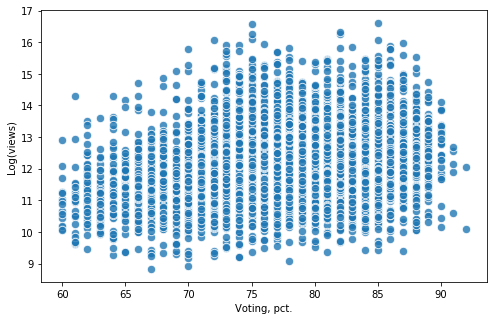

In [49]:
fig, ax = pyplot.subplots(figsize=(8,5))
ax=sns.regplot(x=df_des.voting,y=np.log(df_des.nb_views),data=df_des,fit_reg=False,scatter_kws={'edgecolors': sns.xkcd_rgb['white'],'s': 70})
ax.set(xlabel='Voting, pct.', ylabel='Log(views)')

# fig.savefig("views_voting.pdf", bbox_inches='tight')

## 2.5 Thumbnails

In [36]:
red=df_im.red
green=df_im.green
blue=df_im.blue
light=df_im.light_score

### 2.5.1 Red

[Text(0,0.5,'Red'), Text(0.5,0,'log(views)')]

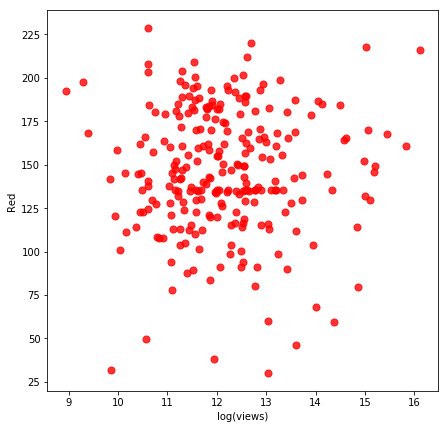

In [37]:
fig, ax = pyplot.subplots(figsize=(7,7))
ax=sns.regplot(x=np.log(df_im.nb_views), y=red, color='red', fit_reg=False, scatter_kws={'s':50})
ax.set(xlabel='log(views)', ylabel='Red')

# fig.savefig("im_red.pdf", bbox_inches='tight')

### 2.5.2 Green

[Text(0,0.5,'Green'), Text(0.5,0,'log(views)')]

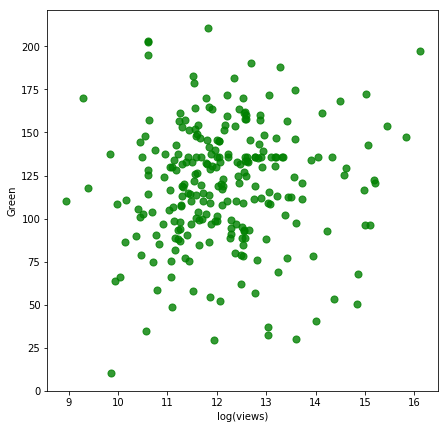

In [38]:
fig, ax = pyplot.subplots(figsize=(7,7))
ax=sns.regplot(x=np.log(df_im.nb_views), y=green, color='green', fit_reg=False, scatter_kws={'s':50})
ax.set(xlabel='log(views)', ylabel='Green')

# fig.savefig("im_green1.pdf", bbox_inches='tight')

### 2.5.3 Blue

[Text(0,0.5,'Blue'), Text(0.5,0,'log(views)')]

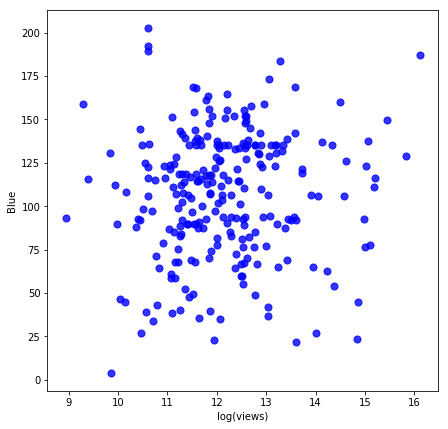

In [39]:
fig, ax = pyplot.subplots(figsize=(7,7))
ax=sns.regplot(x=np.log(df_im.nb_views), y=blue, color='blue', fit_reg=False, scatter_kws={'s':50})
ax.set(xlabel='log(views)', ylabel='Blue')

# fig.savefig("im_blue1.pdf", bbox_inches='tight')

### 2.5.4 Light

[Text(0,0.5,'Light'), Text(0.5,0,'log(views)')]

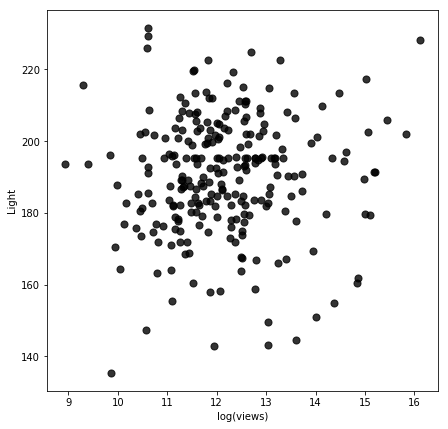

In [40]:
fig, ax = pyplot.subplots(figsize=(7,7))
ax=sns.regplot(x=np.log(df_im.nb_views), y=light, color='black', fit_reg=False, scatter_kws={'s':50})
ax.set(xlabel='log(views)', ylabel='Light')

# fig.savefig("im_light1.pdf", bbox_inches='tight')

# 3. Machine Learningimport warnings

## 3.1 Packages

In [4]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 
import seaborn as sns

%matplotlib inline

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.metrics import mean_squared_error as mse
from sklearn.pipeline import make_pipeline
from math import sqrt
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import GridSearchCV

## 3.2 Import data

In [5]:
df = pd.read_csv('df_5000.csv', sep = ',') #This is a sample of the modified dataset on 5000 observations.
df= pd.read_csv('df_250_images.csv', sep = ',') #This is a sample of the modified dataset including the thumbnail features on 250 observations
df=df.drop('Unnamed: 0', axis=1)
df['y']=np.log(df.nb_views)
y=df.y.copy()
X=df.drop('nb_views', axis=1)
X
X_small=X.iloc[:,0:3]

X_large=X.iloc[:,3:]

FileNotFoundError: [Errno 2] File b'df_5000.csv' does not exist: b'df_5000.csv'

## 3.3 Polynomial Features

In [5]:
#Poly features
pipe_poly=make_pipeline(PolynomialFeatures(2, include_bias=False))

X_=pipe_poly.fit_transform(X_small)

X_poly=pd.DataFrame(X_)
X_poly.columns = ['length', 'voting','age', 'length_sq','lenght_voting','length_age','voting_sq','voting_age','age_sq']
X=X_poly.join(X_large)


In [121]:
#Splitter i test og train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=1)

## 3.4 OLS

In [123]:
pipe_ols = make_pipeline(StandardScaler(), LinearRegression()) #builds pipe
pipe_ols.fit(X_train, y_train)
mseCV_train_ols=(mse(y_train,pipe_ols.predict(X_train)))    #predict on validatio
mseCV_test_ols=(mse(y_test,pipe_ols.predict(X_test)))   #predict on validation
print('Train MSE: '+str(mseCV_train_ols))
print('Test MSE: '+str(mseCV_test_ols))


Train MSE: 8.909710607928196e-29
Test MSE: 0.40745021850016855


In [ ]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, validation_scores = \
    learning_curve(estimator=pipe_ols,
                   X=X_train,
                   y=y_train,
                   train_sizes=np.linspace(0.1, 1.0, 10), #array from 0.1  to 1, share of observations used
                   scoring='neg_mean_squared_error',  #Turns from min prob to max prob.                
                   cv=10) #Crossvalidation steps
    
#minus again, reverts
mse_ols = pd.DataFrame({'Train':-train_scores.mean(axis=1),
                     'Validation':-validation_scores.mean(axis=1)})\
        .set_index(pd.Index(train_sizes,name='sample size'))   
mse_ols

### 3.4.1 OLS Learning curve 

In [6]:
f_learn, ax = plt.subplots(figsize=(10,4))
mse_ols.plot(ax=ax, logy=True)
ax.fill_between(train_sizes,
                -train_scores.mean(1) + train_scores.std(1)*1.96,
                -train_scores.mean(1) - train_scores.std(1)*1.96, 
                alpha=0.25, 
                color='orange')
ax.set_ylabel('Mean squared error')
ax.set_xlabel('Sample Size')
# f_learn.savefig("OLS_learning_curve.pdf", bbox_inches='tight')

## 3.5 LASSO

In [104]:
lambdas =  np.logspace(-3, 1, 100)

    
pipe_lasso = make_pipeline(StandardScaler(), Lasso(random_state=1)) #Pipe
      
#Grid search
gs = GridSearchCV(estimator=pipe_lasso, 
                  param_grid=[{'lasso__alpha':lambdas}], #Now two hyperparameters
                  scoring='neg_mean_squared_error', 
                  cv=10, n_jobs=-1)

gs = gs.fit(X_train, y_train) #fits
print(gs.best_params_) # prints best parameters

lasso_alpha=gs.best_params_.get('lasso__alpha') #extract best parameters


#Builds final pipeline with best parameters
pipe_lasso_final = make_pipeline(StandardScaler(), Lasso(alpha=lasso_alpha,random_state=1)) 
pipe_lasso_final.fit(X_train, y_train)

#Stores performance using the prefered parameter from the cross validation
mseCVlasso_train=mse(y_train,pipe_lasso_final.predict(X_train))    #predict on train
mseCVlasso_test=mse(y_test,pipe_lasso_final.predict(X_test))   #predict on test
print(mseCVlasso_test)
print(mseCVlasso_train)

{'lasso__alpha': 0.1261856883066021}


### 3.5.1 LASSO Learning curve

Text(0,0.5,'Mean squared error')

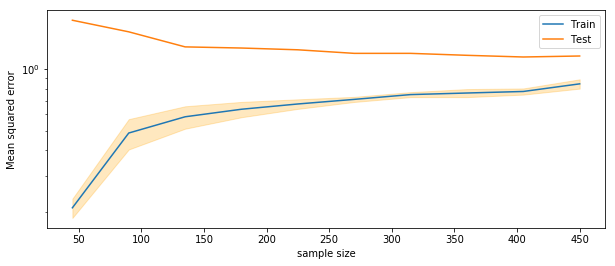

In [396]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = \
    learning_curve(estimator=pipe_lasso_final,
                   X=X_train,
                   y=y_train,
                   train_sizes=np.linspace(0.1, 1.0, 10), #array from 0.1  to 1, share of observations used
                   scoring='neg_mean_squared_error',  #Turns from min prob to max prob.                
                   cv=10) #Crossvalidation steps
    
#minus again, reverts
mse_lasso = pd.DataFrame({'Train':-train_scores.mean(axis=1),
                     'Test':-test_scores.mean(axis=1)})\
        .set_index(pd.Index(train_sizes,name='sample size'))   
mse_lasso

f_learn, ax = plt.subplots(figsize=(10,4))
mse_lasso.plot(ax=ax, logy=True)
ax.fill_between(train_sizes,
                -train_scores.mean(1) + train_scores.std(1)*1.96,
                -train_scores.mean(1) - train_scores.std(1)*1.96, 
                alpha=0.25, 
                color='orange')
ax.set_ylabel('Mean squared error')
#

### 3.5.2 LASSO validation curve

In [76]:
from sklearn.model_selection import validation_curve

lambdas =  np.logspace(-3, 1, 100)

train_scores, test_scores = \
    validation_curve(estimator=pipe_lasso,
                     X=X_train,
                     y=y_train,
                     param_name='lasso__alpha', #name of hyperpara in question
                     param_range=lambdas, #range of the hyperpara
                     scoring='neg_mean_squared_error',                 
                     cv=10)
    
mse_val_lasso = pd.DataFrame({'Train':-train_scores.mean(axis=1),
                          'Test':-test_scores.mean(axis=1),
                          'lambda':lambdas})\
              .set_index('lambda')  
mse_val_lasso
print(mse_val_lasso.Test.nsmallest(1))

lambda
0.017886    0.974837
Name: Test, dtype: float64


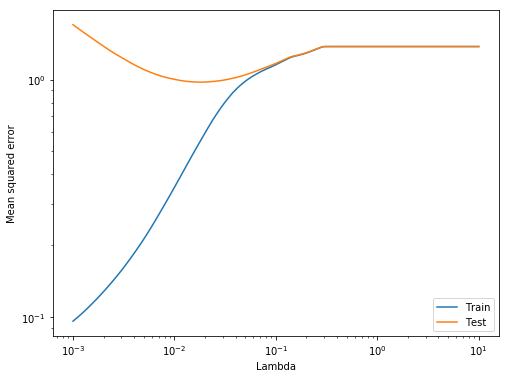

In [77]:
# mse_val_lasso.plot(logx=True, logy=True)
fig_1, ax = plt.subplots(figsize=(8,6))
mse_val_lasso.plot(ax=ax,logx=True, logy=True)
ax.set_xlabel('Lambda')
ax.set_ylabel('Mean squared error')

fig_1.savefig("lasso_validation_curve.pdf", bbox_inches='tight')

## 3.6 Elastic net

In [54]:
from sklearn.linear_model import ElasticNet
mseCVela_train = []
mseCVela_test = []

lambdas =  np.logspace(-2, 1, 50)
ratios = np.linspace(0,1,10)
pipe_ela = make_pipeline(StandardScaler(), ElasticNet(random_state=1)) 
pipe_ela.fit(X_train, y_train)
#mseCVela_train.append(mse(pipe_ela.predict(X_train), y_train))    #predict on validation
#mseCVela_test.append(mse(pipe_ela.predict(X_test), y_test))   #predict on validation

gs = GridSearchCV(estimator=pipe_ela, 
                  param_grid=[{'elasticnet__alpha':lambdas, 
                               'elasticnet__l1_ratio':ratios}], #Now two hyperparameters
                  scoring='neg_mean_squared_error', 
                  cv=10, n_jobs=-1)

gs = gs.fit(X_train, y_train)
print('ELA'+str(gs.best_params_))


ela_alpha=gs.best_params_.get('elasticnet__alpha')
ela_ratio=gs.best_params_.get('elasticnet__l1_ratio')

pipe_ela_final = make_pipeline(StandardScaler(), ElasticNet(alpha=ela_alpha,l1_ratio=ela_ratio,random_state=1)) 
pipe_ela_final.fit(X_train, y_train)

# #mseCVlasso_train = []
# # mseCVlasso_test = []


mseCVela_train=mse(y_train,pipe_ela_final.predict(X_train))    #predict on validation
mseCVela_test=mse(y_test,pipe_ela_final.predict(X_test))   #predict on validation
print(mseCVela_train)
print(mseCVela_test)

ELA{'elasticnet__alpha': 0.29470517025518095, 'elasticnet__l1_ratio': 0.3333333333333333}
0.6491861552460834
1.7072554680878045


### 3.6.1 Elastic Net learning curve

In [ ]:
pipe_ela_final = make_pipeline(StandardScaler(), ElasticNet(alpha=0.12648552168552957,l1_ratio=1/9,random_state=1)) 
pipe_ela_final.fit(X_train, y_train)


train_sizes, train_scores, validation_scores = \
    learning_curve(estimator=pipe_ela_final,
                   X=X_train,
                   y=y_train,
                   train_sizes=np.linspace(0.1, 1.0, 10), #array from 0.1  to 1, share of observations used
                   scoring='neg_mean_squared_error',  #Turns from min prob to max prob.                
                   cv=10) #Crossvalidation steps
    
#minus again, reverts
mse_ela = pd.DataFrame({'Train':-train_scores.mean(axis=1),
                     'Validation':-validation_scores.mean(axis=1)})\
        .set_index(pd.Index(train_sizes,name='sample size'))   
mse_ela
f_learn, ax = plt.subplots(figsize=(10,4))
mse_ela.plot(ax=ax, logy=True)
ax.fill_between(train_sizes, #HVORFOR PLACERES DET HER FARVE SÅ UNDERLIGT? 
                -train_scores.mean(1) + train_scores.std(1)*1.96,
                -train_scores.mean(1) - train_scores.std(1)*1.96, 
                alpha=0.25, 
                color='orange')
ax.set_ylabel('Mean squared error')
ax.set_xlabel('Sample size')
# ax.set_xlabel('Sample Size')

### 3.6.2 Elastic Net validation curve

In [408]:
from sklearn.model_selection import validation_curve

train_scores, test_scores = \
    validation_curve(estimator=pipe_ela_final,
                     X=X_train,
                     y=y_train,
                     param_name='elasticnet__alpha', #name of hyperpara in question
                     param_range=lambdas, #range of the hyperpara
                     scoring='neg_mean_squared_error',                 
                     cv=10)
    
mse_val_ela = pd.DataFrame({'Train':-train_scores.mean(axis=1),
                          'Test':-test_scores.mean(axis=1),
                          'elasticnet__alpha':lambdas})\
              .set_index('elasticnet__alpha')  
mse_val_ela
print(mse_val_ela.Test.nsmallest(1))
mse_val_ela.plot(logx=True, logy=True)

elasticnet__alpha
0.497702    1.118471
Name: Test, dtype: float64


elasticnet__l1_ratio
0.0    1.130629
Name: Test, dtype: float64


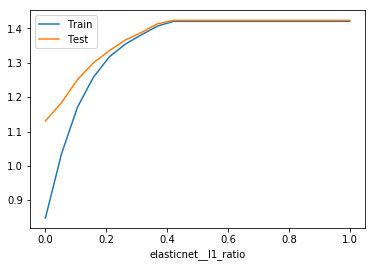

In [411]:
from sklearn.model_selection import validation_curve

train_scores, test_scores = \
    validation_curve(estimator=pipe_ela_final,
                     X=X_train,
                     y=y_train,
                     param_name='elasticnet__l1_ratio', #name of hyperpara in question
                     param_range=ratios, #range of the hyperpara
                     scoring='neg_mean_squared_error',                 
                     cv=10)
    
mse_val_ela = pd.DataFrame({'Train':-train_scores.mean(axis=1),
                          'Test':-test_scores.mean(axis=1),
                          'elasticnet__l1_ratio':ratios})\
              .set_index('elasticnet__l1_ratio')  
mse_val_ela
print(mse_val_ela.Test.nsmallest(1))
mse_val_ela.plot()

## 3.7 Random forest regression

In [35]:
from sklearn.ensemble import RandomForestRegressor

number_esti =  range(500,2500,500)
depth = range(1,100,10)

pipe_randforest = make_pipeline(RandomForestRegressor(random_state=1)) 


gs = GridSearchCV(estimator=pipe_randforest, 
                  param_grid=[{'randomforestregressor__n_estimators':number_esti, 
                              'randomforestregressor__max_depth':depth}], #Now two hyperparameters
                  scoring='neg_mean_squared_error', 
                  cv=10, n_jobs=-1)

gs = gs.fit(X_train, y_train)
gs.best_params_

rand_forest_number=gs.best_params_.get('randomforestregressor__n_estimators')
rand_forest_depth=gs.best_params_.get('randomforestregressor__max_depth')

pipe_randforest_final = make_pipeline(RandomForestRegressor(random_state=1, n_estimators=rand_forest_number,max_depth=rand_forest_depth))
pipe_randforest_final.fit(X_train, y_train)

mseCVforest_train=mse(y_train,pipe_randforest_final.predict(X_train))    #predict on validation
mseCVforest_test=mse(y_test,pipe_randforest_final.predict(X_test))   #predict on validation


gs.best_params_